# Chapter 03 - Classification 

In the first chapter the author mentioned that the most common form of supervised learning tasks are regression (where we are prediciting continuous variables) and classification (prediciting classes). In the previous chapter we explored a regression task, where we looked at prediciting the house prices using several types of algorithms, such as linear regression, decision trees and random forests. In this chapter, we are going to look at classification tasks. 

### MNIST Dataset 

For this chapter we will be using the MNIST dataset, this is a dataset of 70 thousand labelled images of handwritten numbers. The set has been studied so much that it is often called the "hello world" of machine learning (thinking back to when I did my first hello world when I started to learn coding). Whenever people come up with new classification algorithms, the first thing they do is test it on the MNIST dataset to see how it fairs. Anyone who does machine learning or is learning machine learning has tackled or is going to tackle this dataset at some point!!!!

Scikit-learn provides many helper funtions to download popular datasets such as the MNIST dataset, the following code fetches the dataset for us. 

In [1]:
from sklearn.datasets import fetch_openml 

mnist = fetch_openml('mnist_784', version=1, as_frame = False) # we need to set the as_frame = false as skikit learn has updated

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets that are loaded in my scikit learn generally have a similar dictionary structure that include the following. 

- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one colum per feature 
- A target key that contains all of the labels for each of the instances

Let's look at these arrays below

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70 thousand iages and each image is made up of 784 features. This is because each image is 28 x 28 pixels and each feature is simply representing the pixels intensity from 0 (which is white) to 255 (which is black). Lets take a look at one of the digits on our dataset. All we need to do is grab an instances feature vector (we know what these are now) and reshape it into the 28 x 28 array, and thi display it using Matplotlibs imshow() function. 

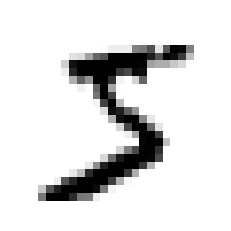

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

first_digit = X[0]

first_digit_image = first_digit.reshape(28, 28)

plt.imshow(first_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

Perfect it's a five, note that the label is a string. Most ML algorithms expect numbers to be fed into them lets cast y to an integer. 

In [14]:
# converting all of the strings into integers
y = y.astype(np.uint8)

Remember that before we go onto analyse the dataset we need to create a test set. The MNIST dataset is actually already split into a training and test split (the first 60,000 are training and the last 10,000 is testing) so lets create our test train split. 

In [17]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

It should be noted that the dataset is already shuffled which is good because it means that the cross validation folds should contain similar amount of each digit, as well as this machine learning algorithms don't tend to like being fed instances that are too similar one after eachother, shuffling the dataset ensures this wont happen. 